In [1]:

from __future__ import print_function

import SimpleITK as sitk

%matplotlib inline
import matplotlib.pyplot as plt
from CnM import gui
import os
os.chdir("..")
import panda as pd

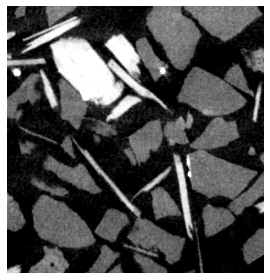

In [15]:
img = sitk.ReadImage('inference/predictions/0.13982934191561683.mha')
img_2=sitk.ReadImage('inference/predictions/wdabig.mha')/256

gui.MultiImageDisplay(image_list = [img_2], figure_size=(8,4));

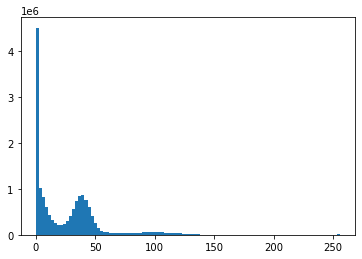

In [16]:
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(img_2).flatten(), bins=100)
plt.show()




Threshold used: 120


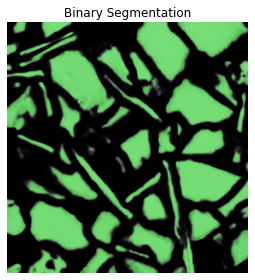

In [17]:
threshold_filters = {'Otsu': sitk.OtsuThresholdImageFilter(),
                     'Triangle' : sitk.TriangleThresholdImageFilter(),
                     'Huang' : sitk.HuangThresholdImageFilter(),
                     'MaxEntropy' : sitk.MaximumEntropyThresholdImageFilter()}

filter_selection = 'Manual'
try:
  thresh_filter = threshold_filters[filter_selection]
  thresh_filter.SetInsideValue(0)
  thresh_filter.SetOutsideValue(1)
  thresh_img = thresh_filter.Execute(img)
  thresh_value = thresh_filter.GetThreshold()
except KeyError:
  thresh_value = 120
  thresh_img = img>thresh_value

print("Threshold used: " + str(thresh_value))    
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(img, thresh_img)],                   
                      title_list = ['Binary Segmentation'], figure_size=(8,4));

Threshold used: 25


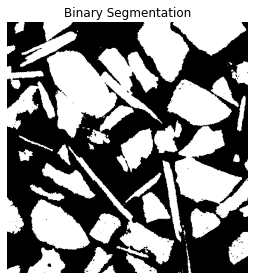

In [47]:
threshold_filters = {'Otsu': sitk.OtsuThresholdImageFilter(),
                     'Triangle' : sitk.TriangleThresholdImageFilter(),
                     'Huang' : sitk.HuangThresholdImageFilter(),
                     'MaxEntropy' : sitk.MaximumEntropyThresholdImageFilter()}

filter_selection = 'Manual'
try:
  thresh_filter = threshold_filters[filter_selection]
  thresh_filter.SetInsideValue(0)
  thresh_filter.SetOutsideValue(1)
  thresh_img_2 = thresh_filter.Execute(img_2)
  thresh_value_2 = thresh_filter.GetThreshold()
except KeyError:
  thresh_value = 25
  thresh_img_2 = img_2>thresh_value
#thresh_img_2 = img_2>50


print("Threshold used: " + str(thresh_value))    
gui.MultiImageDisplay(image_list = [ thresh_img_2],                   
                      title_list = ['Binary Segmentation'], figure_size=(8,4));

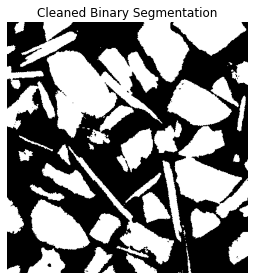

In [62]:
cleaned_thresh_img_2 = sitk.BinaryClosingByReconstruction(thresh_img_2, [10, 10, 10])

gui.MultiImageDisplay(image_list = [cleaned_thresh_img_2],                   
                      title_list = ['Cleaned Binary Segmentation'], figure_size=(8,4));

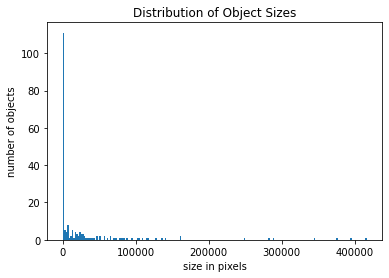

In [19]:
stats = sitk.LabelShapeStatisticsImageFilter()
stats.Execute(sitk.ConnectedComponent(thresh_img))

# Look at the distribution of sizes of connected components (bacteria).
label_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels() if l != 1]

plt.figure()
plt.hist(label_sizes,bins=200)
plt.title("Distribution of Object Sizes")
plt.xlabel("size in pixels")
plt.ylabel("number of objects")
plt.show()



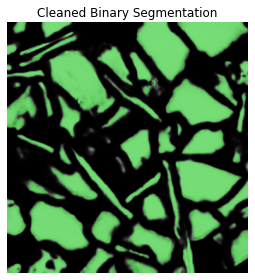

In [20]:
#cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(thresh_img, [10, 10, 10])
cleaned_thresh_img = sitk.BinaryClosingByReconstruction(thresh_img, [10, 10, 10])

gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(img, cleaned_thresh_img)],                   
                      title_list = ['Cleaned Binary Segmentation'], figure_size=(8,4));



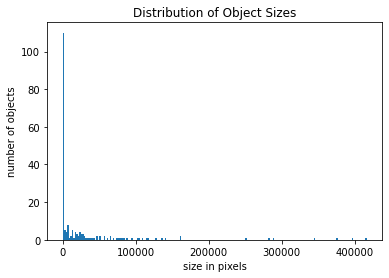

In [21]:
stats = sitk.LabelShapeStatisticsImageFilter()
stats.Execute(sitk.ConnectedComponent(cleaned_thresh_img))

# Look at the distribution of sizes of connected components (bacteria).
label_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels() if l != 1]

plt.figure()
plt.hist(label_sizes,bins=200)
plt.title("Distribution of Object Sizes")
plt.xlabel("size in pixels")
plt.ylabel("number of objects")
plt.show()



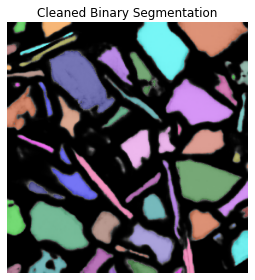

In [22]:
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(img, sitk.ConnectedComponent(cleaned_thresh_img))],                   
                      title_list = ['Cleaned Binary Segmentation'],figure_size=(8,4));



In [63]:
dist_img = sitk.SignedMaurerDistanceMap(cleaned_thresh_img_2 != 0, insideIsPositive=False, squaredDistance=False, useImageSpacing=False)
radius = 0
# Seeds have a distance of "radius" or more to the object boundary, they are uniquely labelled.

seeds = sitk.ConnectedComponent(thresh_img)
# Relabel the seed objects using consecutive object labels while removing all objects with less than 15 pixels.

seeds = sitk.RelabelComponent(seeds, minimumObjectSize=50)
# Run the watershed segmentation using the distance map and seeds.
ws = sitk.MorphologicalWatershedFromMarkers(dist_img, seeds, markWatershedLine=True)
ws = sitk.Mask( ws, sitk.Cast(cleaned_thresh_img_2, ws.GetPixelID()))

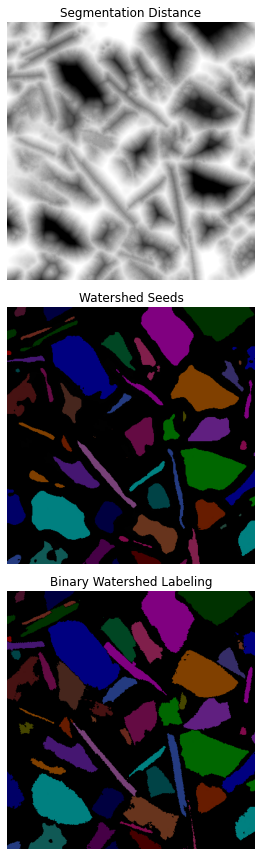

In [64]:
gui.MultiImageDisplay(image_list = [dist_img,
                                    sitk.LabelOverlay(thresh_img_2, seeds),
                                    sitk.LabelOverlay(thresh_img_2, ws)],                   
                      title_list = ['Segmentation Distance',
                                    'Watershed Seeds',
                                    'Binary Watershed Labeling'],
                      shared_slider=True,
                      horizontal=False,
                      figure_size=(6,12));



In [68]:
sitk.WriteImage(sitk.LabelOverlay(img, ws), 'ws.mha')
sitk.WriteImage( ws, 'wdabdwaig.mha')
sitk.WriteImage(sitk.LabelOverlay(img, seeds), 'seed.mha')

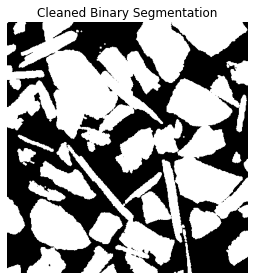

In [72]:
adw=sitk.BinaryDilate(cleaned_thresh_img_2, [1, 1, 1])
gui.MultiImageDisplay(image_list = [adw],                   
                      title_list = ['Cleaned Binary Segmentation'], figure_size=(8,4));

In [76]:

non_border_seg=ws
shape_stats = sitk.LabelShapeStatisticsImageFilter()
shape_stats.ComputeOrientedBoundingBoxOn()
shape_stats.Execute(non_border_seg)

intensity_stats = sitk.LabelIntensityStatisticsImageFilter()
intensity_stats.Execute(non_border_seg,img) 

In [77]:
shape_stats.ComputeOrientedBoundingBoxOn()
shape_stats.Execute(non_border_seg)

intensity_stats = sitk.LabelIntensityStatisticsImageFilter()
intensity_stats.Execute(non_border_seg,img) 



In [81]:
stats_list = [ (shape_stats.GetPhysicalSize(i),
               shape_stats.GetElongation(i),
               shape_stats.GetFlatness(i),
               shape_stats.GetOrientedBoundingBoxSize(i)[0],
               shape_stats.GetOrientedBoundingBoxSize(i)[2],
               intensity_stats.GetMean(i),
               intensity_stats.GetStandardDeviation(i),
               intensity_stats.GetSkewness(i)) for i in shape_stats.GetLabels()]
cols=["Volume (nm^3)",
      "Elongation",
      "Flatness",
      "Oriented Bounding Box Minimum Size(nm)",
      "Oriented Bounding Box Maximum Size(nm)",
     "Intensity Mean",
     "Intensity Standard Deviation",
     "Intensity Skewness"]
import pandas as pd
stats = pd.DataFrame(data=stats_list, index=shape_stats.GetLabels(), columns=cols)
stats.describe()

,Volume (nm^3),Elongation,Flatness,Oriented Bounding Box Minimum Size(nm),Oriented Bounding Box Maximum Size(nm),Intensity Mean,Intensity Standard Deviation,Intensity Skewness
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,60635.950820,1.919478,2.815469,28.303657,77.266003,138.866136,67.675695,-0.662098
std,97885.970602,0.998614,2.615074,21.451403,43.492092,45.613294,19.279162,0.969502
min,13.000000,1.051570,1.028640,2.152765,11.179154,20.081675,7.910558,-3.274525
25%,2302.250000,1.346040,1.495354,11.118255,42.173883,104.494306,56.586870,-1.199534
50%,19903.000000,1.628386,1.928635,22.644632,79.688088,144.845936,72.468336,-0.626681
75%,76953.250000,2.024692,2.616071,40.067368,98.369438,175.367453,83.268901,-0.028037
max,575917.000000,7.078295,18.376013,92.188855,200.900862,218.316100,94.890614,2.496881


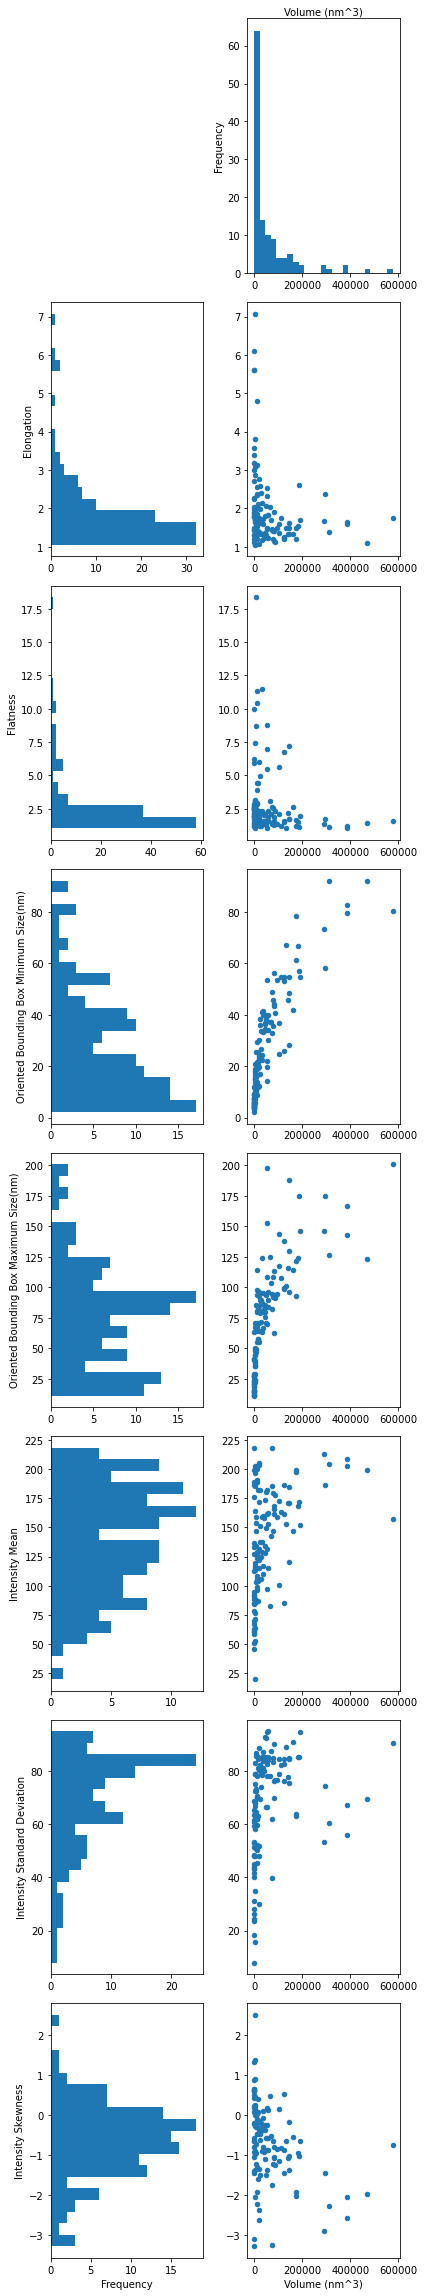

In [82]:
fig, axes = plt.subplots(nrows=len(cols), ncols=2, figsize=(6,4*len(cols)))
axes[0,0].axis('off')

stats.loc[:,cols[0]].plot.hist(ax=axes[0,1], bins=25)
axes[0,1].set_xlabel(cols[0])
axes[0,1].xaxis.set_label_position("top")

for i in range(1,len(cols)):
    c = cols[i]
    bar = stats.loc[:,[c]].plot.hist(ax=axes[i,0], bins=20,orientation='horizontal',legend=False)
    bar.set_ylabel(stats.loc[:,[c]].columns.values[0])    
    scatter = stats.plot.scatter(ax=axes[i,1],y=c,x=cols[0])
    scatter.set_ylabel('')
    # Remove axis labels from all plots except the last (they all share the labels)
    if(i<len(cols)-1):
        bar.set_xlabel('')
        scatter.set_xlabel('')
# Adjust the spacing between plot columns and set the plots to have a tight
# layout inside the figure.
plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
